## The dataset

For this notebook I will use a [snapshot of the S&P 500 at February 2023](https://www.kaggle.com/datasets/sndorburian/e-mini-s-and-p-500-es-feb-10-2023). 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
import pandas as pd
df = pd.read_csv('trading.csv')
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/10/2023,4099.75,1698239.0,4098.00,4104.25,4060.75
1,02/09/2023,4091.75,1777929.0,4132.25,4170.25,4078.25
2,02/08/2023,4130.50,1736222.0,4167.25,4179.25,4121.25
3,02/07/2023,4175.75,2124506.0,4123.50,4188.25,4098.25
4,02/06/2023,4123.50,1516784.0,4134.25,4143.00,4104.00


In [4]:
df.shape

(2544, 6)

In [5]:
df.tail()

,Date,Close/Last,Volume,Open,High,Low
2539,02/15/2013,1517.10,1674261.0,1516.75,1521.75,1511.25
2540,02/14/2013,1518.25,2448.0,1518.75,1519.00,1518.25
2541,02/13/2013,1516.25,997.0,1516.25,1516.50,1516.00
2542,02/12/2013,1517.75,1883.0,1517.50,1518.00,1517.50
2543,02/11/2013,1512.75,1755.0,1512.50,1513.00,1512.25


Based on:
> *The exercise-settlement value, SET, is calculated using the opening sales price in the primary market of each component security on the expiration date. The exercise-settlement amount is equal to the difference between the exercise-settlement value and the exercise price of the option, multiplied by $100.* 

I will calculate settlement from `(High - Open) * 100`. 

*This will be an approximation of the values, because so far I don't have the exact sources to calculate the exact values I will use this approximation. This also means that the results can't be used as real market results!*

In [6]:
df['Settle'] = (df['High']-df['Open'])*100
df.tail()

,Date,Close/Last,Volume,Open,High,Low,Settle
2539,02/15/2013,1517.10,1674261.0,1516.75,1521.75,1511.25,500.0
2540,02/14/2013,1518.25,2448.0,1518.75,1519.00,1518.25,25.0
2541,02/13/2013,1516.25,997.0,1516.25,1516.50,1516.00,25.0
2542,02/12/2013,1517.75,1883.0,1517.50,1518.00,1517.50,50.0
2543,02/11/2013,1512.75,1755.0,1512.50,1513.00,1512.25,50.0


## Creating the predictors

> Predictor variables are data that we think are related to market behavior. These data can be very diverse such as the technical indicators, market data, sentiment data, breadth data, fundamental data, government data, etc. that will help us to make forecasts about the future behavior of the market.
>
> Here we will test the classical indicators for trend following and for range trading, these are:

    EMA
    ATR
    ADX
    RSI
    MACD
    


In [7]:
#We are going to prepare the data by calculating the indicators that we will use as predictors:
import talib as ta
df['EMA10'] = ta.EMA(df['Settle'].values, timeperiod=10)
df['EMA30'] = ta.EMA(df['Settle'].values, timeperiod=30)
df['ATR'] = ta.ATR(df['High'].values, df['Low'].values, df['Settle'].values, timeperiod=14)
df['ADX'] = ta.ADX(df['High'].values, df['Low'].values, df['Settle'].values, timeperiod=14)
df['RSI'] = ta.RSI(df['Settle'].values, timeperiod=14)
macd, macdsignal, macdhist = ta.MACD(df['Settle'].values, fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
df['MACDsignal'] = macdsignal
df.tail()

,Date,Close/Last,Volume,Open,High,Low,Settle,EMA10,EMA30,ATR,ADX,RSI,MACD,MACDsignal
2539,02/15/2013,1517.10,1674261.0,1516.75,1521.75,1511.25,500.0,138.086908,117.445261,1443.852813,26.294488,59.800728,13.514877,-8.507642
2540,02/14/2013,1518.25,2448.0,1518.75,1519.00,1518.25,25.0,117.525652,111.481051,1413.506184,25.432712,48.105751,4.097830,-5.986548
2541,02/13/2013,1516.25,997.0,1516.25,1516.50,1516.00,25.0,100.702806,105.901628,1419.077171,24.746688,48.105751,-3.326897,-5.454618
2542,02/12/2013,1517.75,1883.0,1517.50,1518.00,1517.50,50.0,91.484114,102.295071,1424.357373,24.000408,48.717924,-7.111776,-5.786049
2543,02/11/2013,1512.75,1755.0,1512.50,1513.00,1512.25,50.0,83.941548,98.921196,1427.117560,23.597690,48.717924,-9.996090,-6.628058


> "*EMAs and MACDs do not serve as they are, since the signal comes from the price in relation to averages, or from one average in relation to the other. Let’s calculate the columns that will serve as predictors for the averages and the MACD. Theese will be the possible trading rules.*

In [8]:
df['ClgtEMA10'] = np.where(df['Settle'] > df['EMA10'], 1, -1)
df['EMA10gtEMA30'] = np.where(df['EMA10'] > df['EMA30'], 1, -1)
df['MACDSIGgtMACD'] = np.where(df['MACDsignal'] > df['MACD'], 1, -1)
df.tail()

,Date,Close/Last,Volume,Open,High,Low,Settle,EMA10,EMA30,ATR,ADX,RSI,MACD,MACDsignal,ClgtEMA10,EMA10gtEMA30,MACDSIGgtMACD
2539,02/15/2013,1517.10,1674261.0,1516.75,1521.75,1511.25,500.0,138.086908,117.445261,1443.852813,26.294488,59.800728,13.514877,-8.507642,1,1,-1
2540,02/14/2013,1518.25,2448.0,1518.75,1519.00,1518.25,25.0,117.525652,111.481051,1413.506184,25.432712,48.105751,4.097830,-5.986548,-1,1,-1
2541,02/13/2013,1516.25,997.0,1516.25,1516.50,1516.00,25.0,100.702806,105.901628,1419.077171,24.746688,48.105751,-3.326897,-5.454618,-1,-1,-1
2542,02/12/2013,1517.75,1883.0,1517.50,1518.00,1517.50,50.0,91.484114,102.295071,1424.357373,24.000408,48.717924,-7.111776,-5.786049,-1,-1,1
2543,02/11/2013,1512.75,1755.0,1512.50,1513.00,1512.25,50.0,83.941548,98.921196,1427.117560,23.597690,48.717924,-9.996090,-6.628058,-1,-1,1


- **EMA**, we are interested in **when the price is above average** and when **the fastest average is above the slowest average**.
- **ATR(14)**, we’re interested in **the threshold that will trigger the signal**.
- **ADX(14)**, we’re interested in **the threshold that will trigger the signal**.
- **RSI(14)**, we’re interested in **the threshold that will trigger the signal**.
- **MACD**, we are interested in when **the MACD signal is above MACD**.

## Creating the target variables

> While the classification decision tree tries to characterize the future by offering a categorical variable, i.e. the market goes up or down, the regression decision tree tries to forecast the future value, i.e. the future market price.
>
> We are going to create here the target variables for the two types of problems, although each one will use its own target.

> *Valuing real options, such as expansion options and abandonment options, must be done with the use of decision trees, as their value cannot be determined via the Black-Scholes formula. Real options represent actual decisions a company may make, such as whether to expand or contract operations. For example, an oil and gas company can purchase a piece of land today, and if drilling operations are successful, it can cheaply buy additional lots of land. If drilling is unsuccessful, the company will not exercise the option and it will expire worthless. Since real options provide significant value to corporate projects, they are an integral part of capital budgeting decisions.*
>
> This means that decison trees are not just useful to predict the price, but also a good tool to choose an investment, or to organize a project: 
>
![ Real Option Analysis. Image by Sabrina Jiang © Investopedia 2021](https://www.investopedia.com/thmb/PtkXgrx_QK3G5rKsFtekiYK30W4=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/dotdash_final_Using_Decision_Trees_in_Finance_Jan_2021-04-e7bae9d326e14965b17da31c38b76218.jpg) 

> ## Generally:
> *For example, in a decision tree if the target variable is binary, with categories 1 and 0 ( shown by green and red dots in the image below, then the decision tree works to split the target variable space into sub groups that are more homogenous in terms of having either 1’s or 0’s.*
>
> ![binary decision tree](https://miro.medium.com/v2/resize:fit:828/format:webp/1*HQsjuYNRaphQ0SFXnedqRA.png)

In [9]:
df['Return'] = df['Settle'].pct_change(1).shift(-1)
df['target_cls'] = np.where(df.Return > 0, 1, 0)
df['target_rgs'] = df['Return']
df.head()

,Date,Close/Last,Volume,Open,High,Low,Settle,EMA10,EMA30,ATR,ADX,RSI,MACD,MACDsignal,ClgtEMA10,EMA10gtEMA30,MACDSIGgtMACD,Return,target_cls,target_rgs
0,02/10/2023,4099.75,1698239.0,4098.00,4104.25,4060.75,625.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,5.080000,1,5.080000
1,02/09/2023,4091.75,1777929.0,4132.25,4170.25,4078.25,3800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-0.684211,0,-0.684211
2,02/08/2023,4130.50,1736222.0,4167.25,4179.25,4121.25,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,4.395833,1,4.395833
3,02/07/2023,4175.75,2124506.0,4123.50,4188.25,4098.25,6475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,-0.864865,0,-0.864865
4,02/06/2023,4123.50,1516784.0,4134.25,4143.00,4104.00,875.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,1.057143,1,1.057143


> We must clean the data dropping the NA data, this step is crucial to compute cleanly the trees.

In [10]:
predictors_list = ['ATR', 'ADX','RSI', 'ClgtEMA10', 'EMA10gtEMA30', 'MACDSIGgtMACD']
tmp = df[predictors_list]

tmp = tmp.fillna(0)
highest_non_inf = tmp.max().loc[lambda v: v<np.Inf].max()
tmp.replace(np.Inf, highest_non_inf)

tmp.tail()

,ATR,ADX,RSI,ClgtEMA10,EMA10gtEMA30,MACDSIGgtMACD
2539,1443.852813,26.294488,59.800728,1,1,-1
2540,1413.506184,25.432712,48.105751,-1,1,-1
2541,1419.077171,24.746688,48.105751,-1,-1,-1
2542,1424.357373,24.000408,48.717924,-1,-1,1
2543,1427.117560,23.597690,48.717924,-1,-1,1


In [11]:
predictors_list = ['ATR', 'ADX','RSI', 'ClgtEMA10', 'EMA10gtEMA30', 'MACDSIGgtMACD']
X = tmp[predictors_list]
X.tail()

,ATR,ADX,RSI,ClgtEMA10,EMA10gtEMA30,MACDSIGgtMACD
2539,1443.852813,26.294488,59.800728,1,1,-1
2540,1413.506184,25.432712,48.105751,-1,1,-1
2541,1419.077171,24.746688,48.105751,-1,-1,-1
2542,1424.357373,24.000408,48.717924,-1,-1,1
2543,1427.117560,23.597690,48.717924,-1,-1,1


In [12]:
y_cls = df.target_cls #the target dataset for the classification decision tree
y_cls.tail()

y_rgs = df.target_rgs # the target dataset for the regression decision tree
y_rgs.tail()

2539   -0.95
2540    0.00
2541    1.00
2542    0.00
2543     NaN
Name: target_rgs, dtype: float64

> "*The last step to finish with the preparation of the data sets is to split them into train and test data sets. This is necessary to fit the model with a set of data, usually 70% or 80% and the remainder, to test the goodness of the model. If we do not do so, we would run the risk of over-fitting the model. We want to test the model with unknown data, once the model has been fitted in order to evaluate the model accuracy.*"
>
> "*For classification decision trees, we’re going to use the [traintestsplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from sklearn modelselection library to split the dataset. Since the output is categorical, it is important that the training and test datasets are proportional traintest_split function has as input the predictor and target datasets and some input parameters:*
> - ***test_size:*** *the size of the test data set, in this case, 30% of the data for the tests and, therefore, 70% for the training.*
> - ***random_state:*** *Since the sampling is random, this parameter allows us to reproduce the same randomness in each execution.*
> - ***stratify:*** *To ensure that the training and test sample data are proportional, we set the parameter to yes. This means that, for example, if there are more days with positive than negative return, the training and test samples will keep the same proportion.*"

In [13]:
from sklearn.model_selection import train_test_split
y=y_cls
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X, y, test_size=0.3, random_state=432, stratify=y)

print (X_cls_train.shape, y_cls_train.shape)
print (X_cls_test.shape, y_cls_test.shape)

(1780, 6) (1780,)
(764, 6) (764,)


> Here we have:

    Train predictor variables dataset: X_cls_train
    Train target variables dataset: y_cls_train
    Test predictor variables dataset: X_cls_test
    Test target variables dataset: y_cls_test
> Since the output is continuous, we don’t worry about the proportionality of the output in training and test datasets.

In [14]:
train_length = int(len(df)*0.70)
X_rgs_train = X[:train_length]
X_rgs_test = X[train_length:]
y_rgs_train = y_rgs[:train_length]
y_rgs_test = y_rgs[train_length:]

print (X_rgs_train.shape, y_rgs_train.shape)
print (X_rgs_test.shape, y_rgs_test.shape)

(1780, 6) (1780,)
(764, 6) (764,)


> Again, here we have:

    Train predictor variables dataset: X_rgs_train
    Train target variables dataset: y_rgs_train
    Test predictor variables dataset: X_rgs_test
    Test target variables dataset: y_rgs_test

## Decision Trees for Classification

> Now let’s create the classification decision tree using the DecisionTreeClassifier function from the sklearn.tree library
>
> Basically refer to the parameters with which the algorithm must build the tree, because it follows a recursive approach to build the tree, we must set some limits to create it.
> - **criterion:** For the classification decision trees we can choose Gini or Entropy and Information Gain, these criteria refer to the loss function to evaluate the performance of a learning machine algorithm and are the most used for the classification algorithms, although it is beyond the scope of this post, basically serves us to adjust the accuracy of the model, also the algorithm to build the tree, stops evaluating the branches in which no improvement is obtained according to the loss function.
> - **max_depth:** Maximum number of levels the tree will have.
> - **min_samples_leaf:** This parameter is optimizable and indicates the minimum number of samples that we want to have in leaves.



> ## Generally:
> "*The criterion for selecting variables and hierarchy can be tricky to get, not to mention Gini index, Entropy ( wait, isn’t that physics?) and information gain (isn’t that information theory?). As you can see there are lots of tricky problems on which you can get stuck on.*"
>
> It comprises of the following components:
> - **root node:** this is the node that begins the splitting process by finding the variable that best splits the target variable
> - **Node purity:** Decision nodes are typically impure, or a mixture of both classes of the target variable (0,1 or green and red dots in the image). *Pure nodes are those that have one class — hence the term pure. They either have green or red dots only in the image.*
> - **Decision nodes:** these are subsequent or intermediate nodes, where the target variable is again split further by other variables
> - **Leaf nodes or terminal nodes** are pure nodes, hence are used for making a prediction of a numerical or class is made.
>
>
> ![Structure of a Decision Tree, source: [5]](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*8tFncx9671DOisRXg-eEtw.png)
> 
> In general a decision tree takes a statement or hypothesis or condition and then makes a decision on whether the condition holds or does not.
> 
> The algorithm therefore evaluates all variables on some statistical criteria and then chooses the variable that performs best on the criteria.
> ### Variable selection criterion: Entropy and Information Gain / Gini Index
>
> *Both criteria are broadly similar and seek to determine which variable would split the data to lead to the underlying child nodes being most homogenous or pure. Both are used in different Decision Tree algorithms. To add to the confusion, it is not clear which one is the preferred approach. So, one has to have an understanding of both.*
>
> > #### Entropy
> > In the context of Decision Trees, entropy is a measure of disorder or impurity in a node. Thus, a node with more variable composition, such as 2Pass and 2 Fail would be considered to have higher Entropy than a node which has only pass or only fail. The maximum level of entropy or disorder is given by 1 and minimum entropy is given by a value 0. Leaf nodes which have all instances belonging to 1 class would have an entropy of 0. Whereas, the entropy for a node where the classes are divided equally would be 1. $$E = - \sum_{i=1}^{n}{p_ilog_2(p_i)}$$ where $p_i$ is the probability of randomly selecting an example in class $i$. So, the initial entropy of at the parent node is given by the probability of getting a pass vs fail where:
> > - $p_{pass} = \frac{probability of passing}{total number of instances}$
> > - $p_{fail} = \frac{probability of failing}{total number of instances}$ 
> > Now essentially what a Decision Tree does to determine the root node is to calculate the entropy for each variable and its potential splits. For this we have to calculate a potential split from each variable, calculate the average entropy across both or all the nodes and then the change in entropy vis a vis the parent node. This change in entropy is termed Information Gain and represents how much information a feature provides for the target variable. $$Infomration Gain = entropy_{parrent node} - entropy_{children node}$$ For calculating the root node we have to calculate a potential split from each variable, calculate the average entropy across both the nodes and then the change in entropy via a vis the parent node.
> 
> > #### Gini Index
> > The Gini Index or Impurity measures the probability for a random instance being misclassified when chosen randomly. The lower the Gini Index, the better the lower the likelihood of misclassification.
> > $$Gini = 1 - \sum_{i=1}^{j}{P(i)^2}$$ where $j$ is the number of classes; 
> > 
> > $P(i)$ is the ratio of $\frac{pass}{total number of observations}$ in the node.
> >
> >  The Gini Index has a minimum (highest level of purity) of 0. It has a maximum value of .5. If Gini Index is .5, it indicates a random assignment of classes.
> > Now let us calculate the Gini index for the root node. Gini formula requires us to calculate the Gini Index for each sub node. Then do a weighted average to calculate the overall Gini Index for the node.
>
> #### Conclusion
> Depending on which impurity measurement is used, tree classification results can vary. This can make small (or sometimes large) impact on your model. There seems to be no one preferred approach by different Decision Tree algorithms. *The Gini index has a maximum impurity is 0.5 and maximum purity is 0, whereas Entropy has a maximum impurity of 1 and maximum purity is 0.*




In [15]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=6)
clf

DecisionTreeClassifier(max_depth=3, min_samples_leaf=6)

> Train the model with the training datasets, we fit the model and the algorithm would already be fully trained

In [16]:
clf = clf.fit(X_cls_train, y_cls_train)
clf

DecisionTreeClassifier(max_depth=3, min_samples_leaf=6)

## Visualize Decision Trees for Classification
> Note that the image only shows the most significant nodes. In this graph we can see all the relevant information in each node:
>
> - the predictor variable used to split the data set.
> - the value of Gini impurity.
> - the number of data points available at that node and
> - the number of target variable data points belonging to each class, 1 and 0.

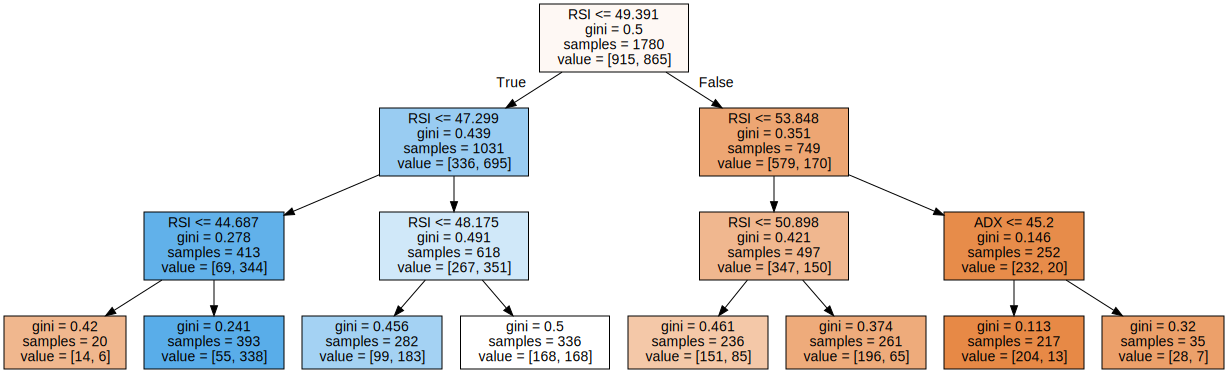

In [17]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,filled=True,feature_names=predictors_list)
graphviz.Source(dot_data)

Remember: "*The Gini Index has a minimum (highest level of purity) of 0. It has a maximum value of .5. If Gini Index is .5, it indicates a random assignment of classes.*"

> We can observe a pair of pure nodes that allows us to deduce a possible trading rules. 

*Now let’s make predictions with data sets reserved for testing, this is the part that will let us know if the algorithm is reliable with unknown data in training.*

In [18]:
y_cls_pred = clf.predict(X_cls_test)

*Finally, we can only evaluate the performance of the algorithm on unknown data by comparing it with the result obtained in the training process. To do this we will use the classification_report function of the sklearn.metrics library

This will generate a text report showing the main calssification metrics, the paramters are:
- Precision: Indicate the quality of our predictions.
- Recall: Indicate the quality of our predictions.
- F1-score: Shows the harmonic mean of precision and recall.
- Support: Used as weights to compute the average values of precision, recall and F-1.

***Anything above 0.5 is usually considered a good number.***

In [19]:
from sklearn.metrics import classification_report
report = classification_report(y_cls_test, y_cls_pred)
print(report)

              precision    recall  f1-score   support

           0       0.67      0.82      0.74       393
           1       0.75      0.57      0.65       371

    accuracy                           0.70       764
   macro avg       0.71      0.70      0.69       764
weighted avg       0.71      0.70      0.69       764



Check if there is any infinite value in the dataset.

In [20]:
if np.all(np.isfinite(X_rgs_train)) or np.all(np.isfinite(y_rgs_train)):
    print("! INFINITE !")

! INFINITE !


Clean the NaN from the dataset.

In [21]:
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
X_rgs_train_with_imputed_values = my_imputer.fit_transform(X_rgs_train)
X_rgs_train1=np.array(X_rgs_train)

In [22]:
X_rgs_train.head()
X_rgs_train.isin([np.inf, -np.inf]).values.any()

False

In [23]:
#import sys
#
#X_rgs_train
#b=X_rgs_train1>sys.float_info.max
#for i in range(a.shape[0]):
#    for j in range(a.shape[1]):
#        if b[i,j]==True:
#            print("NaN at: "+str(i)+", "+str(j))

> Now let’s create the regression decision tree using the DecisionTreeRegressor function from the sklearn.tree library.
>
> Basically refer to the parameters with which the algorithm must build the tree, because it follows a recursive approach to build the tree, we must set some limits to create it.
>
> - ***criterion:*** For the classification decision trees we can choose Mean Absolute Error (MAE) or Mean Square Error (MSE), these criteria are related with the loss function to evaluate the performance of a learning machine algorithm and are the most used for the regression algorithms, although it is beyond the scope of this post, basically serves us to adjust the accuracy of the model, also the algorithm to build the tree, stops evaluating the branches in which no improvement is obtained according to the loss function. Here we left the default parameter to Mean Square Error (MSE).
> - ***max_depth:*** Maximum number of levels the tree will have, here we left the default parameter to none.
> - ***min_samples_leaf:*** This parameter is optimizable and indicates the minimum number of leaves that we want the tree to have.


In [24]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(min_samples_leaf = 200)
X_rgs_train.shape

(1780, 6)

In [25]:
import sys
np.all(X_rgs_train>sys.float_info.max)

False

Remove the too long values by cutting the last characters.

In [26]:
def limitcomma(value, limit=2):
    v = str(value).split(".")
    if len(v)>1:
        return float(v[0]+"."+v[1][:limit])
    else:
        return float("0.0")
#X_rgs_train2=X_rgs_train
y_rgs_train2=y_rgs_train
for i in range(1780):
    for j in range(6):
        #X_rgs_train2.loc[i][j]=limitcomma(X_rgs_train.loc[i][j])
        y_rgs_train2.loc[i]=limitcomma(y_rgs_train.loc[i])

In [27]:
#print(X_rgs_train2.shape)
print(y_rgs_train2.shape)

(1780,)


In [28]:
dtr.fit(X_rgs_train, y_rgs_train2)

DecisionTreeRegressor(min_samples_leaf=200)

Let’s take a graphical look at the regression decision tree that the ML algorithm has automatically created for us.

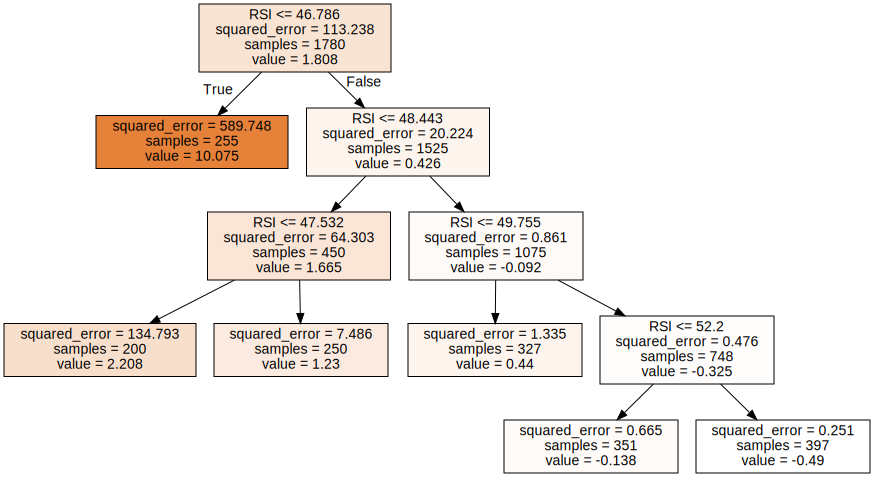

In [29]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(dtr,
                  out_file=None,
                  filled=True,
                  feature_names=predictors_list)
graphviz.Source(dot_data)

> ## Conclusion
>
> It might look like we’ve found a crystal ball, but nothing could be further from the truth. Mastering these techniques requires a lot of study and an integral understanding of the mathematical techniques behind them.
>
> Apparently, trees are easy to create and extract some rules that promise to be useful, but the truth is that to create decision trees, they need to be parametrized and these parameters can and must be optimized.
>
>    Parallel ensemble methods or averaging methods: several models are created by one algorithm and the forecast is the average of the overall models:
> - Bagging
> - Random Subspace
> - Random Forest
>
> Sequential ensemble methods or boosting methods: the algorithm creates sequential models refining on each new model to reduce the bias of the previous one:
> - AdaBoosting
> - Gradient Boosting

*Disclaimer: All investments and trading in the stock market involve risk. Any decisions to place trades in the financial markets, including trading in stock or options or other financial instruments is a personal decision that should only be made after thorough research, including a personal risk and financial assessment and the engagement of professional assistance to the extent you believe necessary. The trading strategies or related information mentioned in this article is for informational purposes only*